In [1]:
import pandas as pd
import numpy as np

brewery_2022_interpolated = pd.read_csv("Data/brewery_production_2022_interpolated.csv")
brewery_2017_2019 = pd.read_csv("Data/brewery_production_2017_2019.csv")
wa_breweries_with_ratings = pd.read_csv("Data/wa_breweries_with_ratings.csv")
wa_breweries_with_ratings = wa_breweries_with_ratings[["brewery", "rating", "total_visits", "unique_visits", "leg_district"]]
wa_breweries_with_ratings['customer_loyalty'] = wa_breweries_with_ratings['total_visits'] / wa_breweries_with_ratings['unique_visits']

In [2]:
brewery_2022_interpolated.columns

Index(['brewery', 'brewery_type', 'address', 'city', 'zipcode', 'county',
       'latitude', 'longitude', 'year_established', 'guild_member',
       'closed_since_2022', 'untappd_profile_link', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'total_annual'],
      dtype='object')

In [3]:
brewery_2022_interpolated["closed_since_2022"].value_counts()

0    356
1     32
Name: closed_since_2022, dtype: int64

In [4]:
brewery_2022_total = pd.DataFrame({
    "brewery_name": brewery_2022_interpolated["brewery"], 
    "annual_production": brewery_2022_interpolated["total_annual"],
    "year": 2022,
    "estimate": 1
})


In [5]:
brewery_2017_2022 = pd.concat([brewery_2022_total, brewery_2017_2019])

In [6]:
def num_handler(s):
    if s == "DNP" or s == "Do Not Publish":
        return np.nan
    if type(s) == str:
        s = s.replace(",", "")
    return float(s)

In [7]:
brewery_2017_2022

,brewery_name,annual_production,year,estimate
0,192 Brewing Company,NaN,2022.0,1.0
1,20 Corners Brewing Company,1481.65,2022.0,1.0
2,23rd Ave Brewery,NaN,2022.0,1.0
3,4 Stitch Brewing Company,NaN,2022.0,1.0
4,45 Degree Brewhouse,87.07,2022.0,1.0
...,...,...,...,...
1224,Willapa Brewing Co,155,2017.0,1.0
1225,Wingman Brewers,876,2017.0,1.0
1226,Yakima Craft Brewing Company,"1,500",2017.0,0.0
1227,Yakima Valley Hops,5,2017.0,1.0


In [8]:
brewery_production_trend = pd.DataFrame(brewery_2017_2022.groupby("brewery_name")["annual_production"].agg(lambda x: np.nan if len(x) == 1 else np.polyfit(np.arange(len(x)), np.array(list(map(lambda v: num_handler(v) ,x.values[::-1]))), 1)[0] / num_handler(x.iloc[-1])))
brewery_production_trend.rename(columns={"annual_production": "production_trend"}, inplace=True)
brewery_production_trend.fillna(0, inplace=True)
brewery_production_size = pd.DataFrame(brewery_2017_2022.groupby("brewery_name")["annual_production"].agg(lambda x: np.sum(list(map(lambda v: num_handler(v) ,x.values)))/len(x)))
# categorize brewery production by percentile
brewery_production_size["annual_production"] = pd.qcut(brewery_production_size["annual_production"], 10, labels=False)
brewery_production_size.fillna(0, inplace=True)
brewery_production_size.rename(columns={"annual_production": "production_size"}, inplace=True)
brewery_production_stat = pd.concat([brewery_production_trend, brewery_production_size], axis=1)

In [9]:
rawDF = pd.merge(brewery_2022_interpolated, brewery_production_stat, left_on="brewery", right_on="brewery_name", how="inner")
rawDF = pd.merge(rawDF, wa_breweries_with_ratings, left_on="brewery", right_on="brewery", how="inner")

In [10]:
rawDF[rawDF['closed_since_2022'] == 1]

,brewery,brewery_type,address,city,zipcode,county,latitude,longitude,year_established,guild_member,...,November,December,total_annual,production_trend,production_size,rating,total_visits,unique_visits,leg_district,customer_loyalty
6,5 North Brewing Company,taproom,6501 N Cedar Rd,Spokane,99208,Spokane,47.717587,-117.432850,2020,0,...,16.04,14.83,267.32,0.182832,5.0,3.63,770.0,256.0,3,3.007812
39,Barlow's Brewery,brewpub,705 SE Park Crest Ave Suite D430,Vancouver,98683,Clark,45.616262,-122.522206,2020,0,...,NaN,NaN,NaN,0.000000,0.0,3.78,3305.0,1458.0,17,2.266804
48,Berchmans Brewing Company,nano,25 North Front Street,Yakima,98901,Yakima,46.602834,-120.507761,2014,0,...,1.00,NaN,NaN,0.000000,0.0,3.55,1334.0,474.0,15,2.814346
77,Camas Brewing Company,taproom,335 NE Cedar St,Camas,98607,Clark,45.585423,-122.403814,2021,0,...,9.58,9.58,144.37,0.000000,3.0,3.57,377.0,219.0,17,1.721461
89,Common Language Brewing Company,micro,"926 W Sprague Ave, Spokane, WA",Spokane,99201,Spokane,47.657515,-117.426234,2022,0,...,13.00,4.50,229.00,0.000000,5.0,3.82,962.0,351.0,3,2.740741
90,Counterbalance Brewing Company,micro,503 S Michigan St Ste B,Seattle,98108,King,47.545389,-122.330586,2015,0,...,13.58,13.58,357.83,-0.135973,7.0,3.72,26687.0,10555.0,34,2.528375
98,Cursed Brewing,taproom,3108 S Lloyd Ln,Spokane,99223,Spokane,47.625965,-117.343766,2022,1,...,4.78,-3.06,6.50,0.000000,0.0,4.25,798.0,164.0,9,4.865854
99,Darach Brewing Company,taproom,1015 N State St,Bellingham,98225,Whatcom,48.745707,-122.481381,2022,0,...,0.00,5.50,5.50,0.000000,0.0,NaN,NaN,NaN,42,NaN
100,Decibel Brewing Company,micro,18204 Bothell Everett Hwy Suite C,Bothell,98012,Snohomish,47.833256,-122.210337,2016,0,...,NaN,4.52,NaN,0.000000,0.0,3.62,5021.0,1386.0,1,3.622655
123,E2W Brewing,micro,12913 Shady Glen Ave SE,Olalla,98359,Kitsap,47.432463,-122.594069,2020,0,...,NaN,NaN,NaN,0.000000,0.0,3.69,459.0,256.0,26,1.792969


In [24]:
dataDF = rawDF[["brewery", 'brewery_type', 'city', 'county', 'latitude', 'longitude', 'leg_district',
       'year_established', 'guild_member',
       'closed_since_2022', "total_annual", "production_trend", "production_size", "rating", "customer_loyalty", "total_visits"]]
dataDF['total_annual'] = dataDF['total_annual'].fillna(0)
dataDF['year_established'] = dataDF['year_established'].apply(lambda x: 2022 - x + 1)
dataDF['average_visits'] = dataDF['total_visits'] / dataDF['year_established']
dataDF['leg_district'] = dataDF["leg_district"].astype("category")

C:\Users\david.chen\AppData\Local\Temp\ipykernel_23820\1929857491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDF['total_annual'] = dataDF['total_annual'].fillna(0)
C:\Users\david.chen\AppData\Local\Temp\ipykernel_23820\1929857491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDF['year_established'] = dataDF['year_established'].apply(lambda x: 2022 - x + 1)
C:\Users\david.chen\AppData\Local\Temp\ipykernel_23820\1929857491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a co

In [25]:
dataDF = pd.get_dummies(dataDF[['latitude', 'longitude', 'brewery_type', 'city', 'county', 'leg_district',
       'year_established', 'guild_member',
       'closed_since_2022', "total_annual", "production_trend", "production_size", "rating", "customer_loyalty", "average_visits"]])
dataDF.dropna(inplace=True)

In [27]:
dataDF.shape

(423, 246)

In [28]:
# find the neighbors' production sizes
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(dataDF[["longitude", "latitude"]])
distances, indices = neigh.kneighbors(dataDF[["longitude", "latitude"]])

# get the production size of neighbors
neighbor_production_size_mean = []
neighbor_production_size_max = []
neighbor_production_size_min = []
neighbor_production_size_std = []
for i in range(len(indices)):
    neighbor_production_size_mean.append(dataDF.iloc[indices[i][1:]]["total_annual"].mean())
    neighbor_production_size_max.append(dataDF.iloc[indices[i][1:]]["total_annual"].max())
    neighbor_production_size_min.append(dataDF.iloc[indices[i][1:]]["total_annual"].min())
    neighbor_production_size_std.append(dataDF.iloc[indices[i][1:]]["total_annual"].std())

dataDF["neighbor_production_size_mean"] = neighbor_production_size_mean
dataDF["neighbor_production_size_max"] = neighbor_production_size_max
dataDF["neighbor_production_size_min"] = neighbor_production_size_min
dataDF["neighbor_production_size_std"] = neighbor_production_size_std

In [29]:
# stats for breweries closed since 2022
dataDF.groupby("closed_since_2022").mean()

,latitude,longitude,year_established,guild_member,total_annual,production_trend,production_size,rating,customer_loyalty,average_visits,...,leg_district_44,leg_district_45,leg_district_46,leg_district_47,leg_district_48,leg_district_49,neighbor_production_size_mean,neighbor_production_size_max,neighbor_production_size_min,neighbor_production_size_std
closed_since_2022,,,,,,,,,,,,,,,,,,,,,
0,47.430574,-121.545891,10.482234,0.487310,1955.707513,1.387283,4.888325,3.733858,3.142763,3852.935266,...,0.025381,0.007614,0.017766,0.010152,0.015228,0.022843,2041.432456,4731.238706,325.521421,2165.208871
1,47.382850,-121.026763,7.689655,0.068966,966.328621,0.057885,3.068966,3.717241,2.788320,1557.857249,...,0.000000,0.000000,0.000000,0.034483,0.000000,0.034483,2826.842414,8714.577586,181.041034,4205.262663


In [30]:
dataDF["closed_since_2022"].value_counts()

0    394
1     29
Name: closed_since_2022, dtype: int64

In [31]:
dataDF.shape

(423, 250)

In [32]:
X = pd.get_dummies(dataDF.drop(columns=["closed_since_2022"])).values
y = dataDF["closed_since_2022"].values

In [34]:
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skm
from sklearn.metrics import roc_auc_score

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.decomposition import PCA

# pca = PCA(n_components=int(np.sqrt(X.shape[1])))
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from ISLP import confusion_table

# kfold grid search with skm
# fit a support vector classifier on the training set
svm = SVC()

kfold = skm.KFold(3, 
                  random_state=seed,
                  shuffle=True)
grid = skm.GridSearchCV(svm,
                        {'C':[0.01,0.1,1,5,10, 100], "gamma": [0.01,0.1,1,5,10,100], "kernel":['linear', 'rbf'], "class_weight":['balanced', None]},
                        refit=True,
                        cv=kfold,
                        scoring='roc_auc')
grid.fit(X_train, y_train)
print("grid best params:", grid.best_params_)

best_ = grid.best_estimator_

# train error rate with best model
y_train_hat = best_.predict(X_train)
print("best estimator train error:", 1 - accuracy_score(y_train, y_train_hat))
print("best estimator train auc:", roc_auc_score(y_train, y_train_hat))

# test error rate with best model
y_test_hat = best_.predict(X_test)
print("best estimator test error:", 1 - accuracy_score(y_test, y_test_hat))
print("best estimator test auc:", roc_auc_score(y_test, y_test_hat))

print(confusion_table(y_train_hat, y_train))
print(confusion_table(y_test_hat, y_test))

grid best params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'linear'}
best estimator train error: 0.056213017751479244
best estimator train auc: 0.9699367088607596
best estimator test error: 0.12941176470588234
best estimator test auc: 0.6694139194139195
Truth        0   1
Predicted         
0          297   0
1           19  22
Truth       0  1
Predicted       
0          71  4
1           7  3


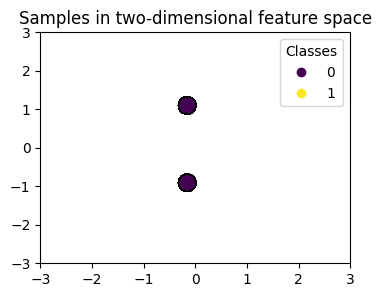

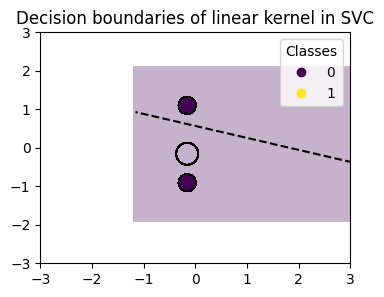

model auc: 0.5


In [38]:
# function to fit a svm with data with 2 features and plot out the decision boundary
import matplotlib.pyplot as plt
def plot_training_data_with_decision_bounary(kernel, X, y, params):

    # Plotting settings
    fig, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot samples by color and add legend
    scatter = ax.scatter(X[:, 0], X[:, 1], s=150, c=y, label=y, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.set_title("Samples in two-dimensional feature space")
    _ = plt.show()

    from sklearn.svm import SVC
    from sklearn.inspection import DecisionBoundaryDisplay
    if kernel == "linear":
        clf = SVC(kernel=kernel, C=params["C"])
    elif kernel == "poly":
        clf = SVC(kernel=kernel, C=params["C"], degree=params["degree"])
    else:
        clf = SVC(kernel=kernel, C=params["C"], gamma=params["gamma"])
    
    clf.fit(X,y)

    # settings for plotting
    _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method = "pcolormesh",
        alpha = 0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels = [-1, 0, 1],
        colors=["k","k","k"],
        linestyles=["--", "-", "--"],
    )

    # plot bigger circles around samples that serve as support vectors
    ax.scatter(
        clf.support_vectors_[:,0],
        clf.support_vectors_[:,0],
        s=250,
        facecolors="none",
        edgecolors="k",
    )

    #plot samples by color and add legend
    ax.scatter(X[:,0], X[:,1], c=y, s=150, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.set_title(f"Decision boundaries of {kernel} kernel in SVC")
    _ = plt.show()

    print("model auc:", roc_auc_score(y, clf.predict(X)))

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_, X_train, y_train)
best_features_idx = np.arange(X.shape[1])[perm_importance.importances_mean.argsort()][-2:]
plot_training_data_with_decision_bounary(grid.best_params_["kernel"], X_train[:,best_features_idx], y_train, grid.best_params_)

Text(0.5, 0, 'Permutation Importance')

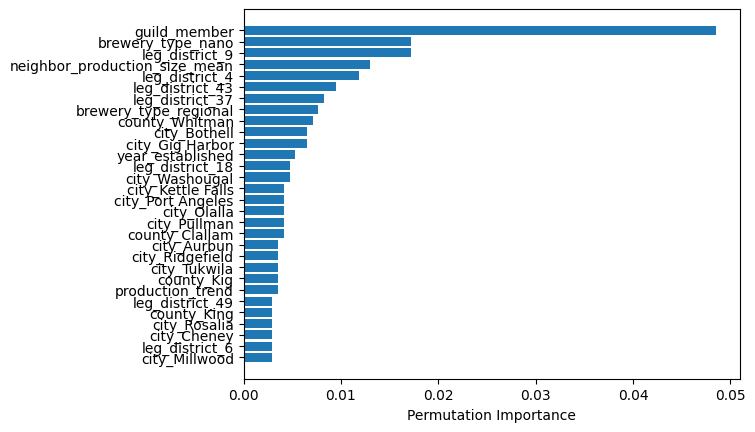

In [39]:
feature_names = dataDF.drop(columns=["closed_since_2022"]).columns
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx[-30:]], perm_importance.importances_mean[sorted_idx[-30:]])
plt.xlabel("Permutation Importance")